# Only thing remaining is Q7 and measurement levels for Q1

# Question 3

In [36]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\n10329935\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\n10329935\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\n10329935\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [37]:
# Loading in dataset
df = pd.read_csv("drugReview.csv")

# as usual, explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3107 non-null   int64 
 1   urlDrugName     3107 non-null   object
 2   rating          3107 non-null   int64 
 3   effectiveness   3107 non-null   object
 4   sideEffects     3107 non-null   object
 5   benefitsReview  3107 non-null   object
dtypes: int64(2), object(4)
memory usage: 145.8+ KB


In [38]:
df.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,benefitsReview
0,0,enalapril,4,Highly Effective,Mild Side Effects,slowed the progression of left ventricular dys...
1,1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,Although this type of birth control has more c...
2,2,ponstel,10,Highly Effective,No Side Effects,I was used to having cramps so badly that they...
3,3,prilosec,3,Marginally Effective,Mild Side Effects,The acid reflux went away for a few months aft...
4,4,lyrica,2,Marginally Effective,Severe Side Effects,I think that the Lyrica was starting to help w...


# Functions

In [39]:
# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
nums = set(string.digits)

# # load the provided stopwords
# df_stop = pd.read_json('Federaliststop.json')

stopwords = sw.words('english')
stopwords = set(['feel', 'good', 'bad', 'stop', 'day'
, 'much', 'like', 'get', 'take', 'go'
, 'able', 'use', 'work', 'hour', 'would',' drug', 'yet', 'week', 
'month', 'start', 'time', 'none', 'start', 'month', 'within', 'help', 'benefit',
'increase', 'well', 'level', 'less', 'medication', 'symptom', 'first', 'one']).union(set(stopwords))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

In [40]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue
            
            # If a number, ignore token and continue
            if all(char in nums for char in token):
                continue


            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['benefitsReview'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms
    
terms = calculate_tf_idf_terms(df['benefitsReview'])

In [42]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()

In [43]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]

    words = []
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :num_word]:
            print(terms[term_idx], end=', ')
            words.append(terms[term_idx])
        print()
    # print(f"Number of duplicate words in the top list: {len(words) - len(set(words))}")
    seen = set()
    uniq = [x for x in words if x in seen or seen.add(x)]    
    print(f"List of repeated words: {uniq}")

## Clustering

C:\Users\n10329935\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\n10329935\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\n10329935\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\n10329935\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will 

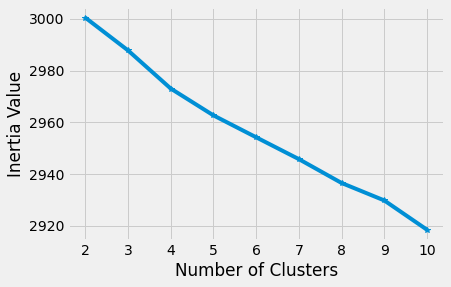

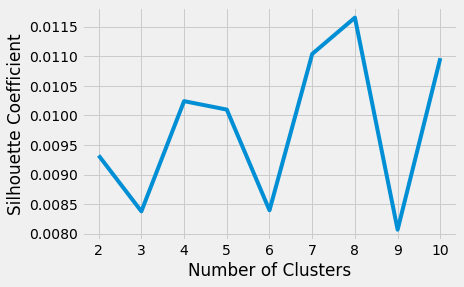

In [56]:
from sklearn.metrics import silhouette_score

stopwords = sw.words('english')
stopwords = set(['feel', 'good', 'bad', 'stop', 'day', 'much', 'like', 'get', 'take', 'go', 'able', 'use', 'work', 'hour', 'would',' drug', 'yet', 'week', 'month', 'start', 'time', 'none', 'start', 'month', 'within', 'help', 'benefit',
'increase', 'well', 'level', 'less', 'medication', 'symptom', 'first', 'one']).union(set(stopwords))

tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X = tfidf_vec.fit_transform(df['benefitsReview'])

rs=42
# Set the random state. different random state seeds might result in different centroids locations
rs = 42

# list to save the clusters and cost
clusters = []
inertia_vals = []
silhouette_coefficients = []


# this whole process should take a while
for k in range(2, 11):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs, n_jobs=10)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    silhouette_coefficients.append(score)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

plt.plot(range(2, 11), inertia_vals, marker='*')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Value")
plt.show()



# A list holds the silhouette coefficients for each k  
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()


In [58]:
l = len(['feel', 'good', 'bad', 'stop', 'day', 'much', 'like', 'get', 'take', 'go', 'able', 'use', 'work', 'hour', 'would',' drug', 'yet', 'week', 'month', 'start', 'time', 'none', 'start', 'month', 'within', 'help', 'benefit',
'increase', 'well', 'level', 'less', 'medication', 'symptom', 'first', 'one'])
print(l)

35


## Answering questions

1. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice  
Clustering done purely with the `benefitsReview` variable. The variable `urlDrugName` can be used for recovering what drugs are in each of the clusters.
2. Based on the ZIPF plot, list the top 10 terms that will be least useful for clustering purpose.
Terms that are too common: `Take`, `Long`, `significantly`, `awesome`, `copd`, `bad shortly`, Terms that are too uncommon: `expose lead`, `active thyroid`, `timeliness`, `derivative`

Zipf plot

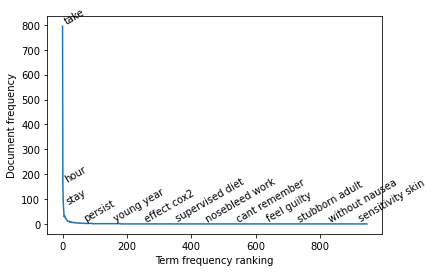

In [51]:
visualise_zipf(terms)


3. Did you disregard any frequent terms? Justify their selection.
When fitting some example clusterings and looking at the top terms in each cluster, it was identified that some terms were being combined into clusters that had no clear meaning behind their combination. To limit these clusters from being created, a list of words were added to the nltk stopwords. The nltk stopwords were used in the beginning because they are generally useful terms that don't differentiate any of the benefits that we were looking for. Also, some clusters had numbers in them. Numbers were not a benefit or side effect, so they were removed (the removal is in the cab_tokenizer function were it passes on numeric characters). The full list of terms that were added to the stopwords can be seen below.

List of terms that were dropped out

In [46]:
removed_words = ['feel', 'good', 'bad', 'stop', 'day', 'much', 'like', 'get', 'take', 'go', 'able', 'use', 'work', 'hour', 'would',' drug', 'yet', 'week', 'month', 'start', 'time', 'none', 'start', 'month', 'within', 'help', 'benefit',
'increase', 'well', 'level', 'less', 'medication', 'symptom', 'first', 'one']

4. Justify the term weighting option selected.
tf-idf was used because if a word was very frequent in a particular document, we would want it to have a higher weight for that document. But, if the word is present in a bunch of other documents, it is probabaly just a common word so we want to reduce the weighting. This helps find more relevent clusters.
5. What is the number of input features available to execute clustering?
7952 features were used. A feature selection algorithm (svd) was tested for performance, but the clusters produced from svd didn't have clear meanings to each cluster. That is why just the raw vector-space representation of the words was used. The reduction in size for the vector-space representation mostly came from adding in extra stopwords.

Number of features

In [47]:
X.shape[1]

7952

6. State how many clusters are generated? Name each cluster meaningfully according to the terms that appear in the clusters?
10 Clusters were fitted because it was found that with 10 clusters, every cluster had a meaning. When adding more clusters, some of the clusters seemed to have no clear meaning (in terms of a side effect or benefit). 

As for the meaning of each cluster:  
Cluster 1 - Hair related things (loss or growth)  
Cluster 2 - Mental health (depression, anxiety, mood)  
Cluster 3 - Infection and cholesterol  
Cluster 4 - Skin related things like acne  
Cluster 5 - Sleep related things like falling asleep or waking up  
Cluster 6 - Digestive things like acid reflux or heartburn  
Cluster 7 - Headaches and migraines  
Cluster 8 - Side effects like depression  
Cluster 9 - Pain relief  

In [57]:
kmeans = KMeans(n_clusters=8, random_state=rs).fit(X)

visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names(), 10)

Top terms for cluster 0: sleep, anxiety, night, depression, help, asleep, take, hot, attack, flash, 
Top terms for cluster 1: take, drug, symptom, treatment, benefit, year, reduce, control, headache, hair, 
Top terms for cluster 2: weight, energy, increase, loss, weight loss, lose, appetite, gain, depression, increase energy, 
Top terms for cluster 3: infection, clear, sinus, sinus infection, infection clear, day, antibiotic, yeast, yeast infection, treatment, 
Top terms for cluster 4: blood, blood pressure, pressure, lower blood, lower, low, low blood, reduce blood, high, high blood, 
Top terms for cluster 5: effect, side effect, side, take, drug, benefit, depression, treatment, without, seem, 
Top terms for cluster 6: skin, acne, clear, reduce, face, use, look, treatment, breakout, pimple, 
Top terms for cluster 7: pain, relief, reduce, take, pain relief, relieve, joint, reduce pain, help, drug, 
List of repeated words: ['take', 'depression', 'treatment', 'take', 'drug', 'benefit', '

7. Identify the first six high frequent terms (that are not stop words) in the start list?
Don't know how to do this yet
8. Describe how these clusters can be useful in the online service for recommending drugs based on their actual benefits to patients.
For each cluster, it can be determined what drug reviews are most represented in each cluster, then they can have the related terms assigned to them. For example below we show how to get the most common drugs in the second cluster (mental health). So these could be recommended as mental health drugs.  

Demonstrating finding out what drugs are in what cluster.

In [49]:
cluster_map = pd.DataFrame()
cluster_map['drug'] = df['urlDrugName']
cluster_map['cluster'] = kmeans.labels_

cluster_map[cluster_map['cluster'] == 1]['drug'].value_counts()

lexapro          48
prozac           39
zoloft           33
paxil            30
effexor          21
                 ..
xanax-xr          1
symbicort         1
vioxx             1
advair-diskus     1
fosamax           1
Name: drug, Length: 151, dtype: int64

## 